In [1]:
# Matplotlib for plotting
%matplotlib inline
from matplotlib import pyplot as plt

# Numpy for almost everything
import numpy as np

# Some scipy functions for sparse diagonal matrices
from scipy.sparse import diags

# scipy function to numerically calculate integral
from scipy.integrate import simps

# By using trange instead of range, we get a nice progress bar
from tqdm import trange

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
from numba import jit

from scipy.integrate import quad

from scipy.interpolate import interp1d

In [2]:
#used the thomas algorithm, taken from another course


# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

In [3]:
#making a finite differences solver for the 1D cases
#we want to take in a array for the different Xs
#this is because we want to have an adaptive mesh refinement, so the x's cant be uniform
def FDM_3pt(X,f):
    
    a = 0
    b = 0
    
    all_rows = 1/(0.5*(X[2:] - X[:-2]))
    
    common_side = 1/(X[2:-1] - X[1:-2])
    
    main = (-1/(X[2:]-X[1:-1]) - 1/(X[1:-1]-X[:-2]))*all_rows
    
    #main = (-1) * 1/(0.5*(X[2:]-X[1:-1])*(X[1:-1]-X[:-2]))
    
    lower_side = common_side * all_rows[1:]
    upper_side = common_side * all_rows[:-1]
    
    A = diags(diagonals = [lower_side, main, upper_side], offsets = [-1,0,1], format = 'csc')
    
    
    F = f(X[1:-1])
    F[0] -= a/(0.5*(X[2]-X[0])*(X[1]-X[0]))
    F[-1] -= b/(0.5*(X[-1]-X[-2])*(X[-1]-X[-3]))
    
    """h=X[1]-X[0]
    F_h = f(X[1:-1])
    F_h[0] -= a/h**2
    F_h[-1] -= b/h**2
    side_h = np.ones(len(X)-3)/h**2
    main_h = np.ones(len(X)-2)*(-2)/h**2
    A_h = diags(diagonals = [side_h, main_h, side_h], offsets = [-1,0,1], format = 'csc')"""

    
    U_inside = tdma(A,F)
    
    
    Us = np.zeros(len(X))
    Us[0] = a
    Us[-1] = b
    Us[1:-1] = U_inside
    
    """U_h_in = tdma(A_h,F_h)
    U_h = np.zeros(len(X))
    U_h[0] = a
    U_h[-1] = b
    U_h[1:-1] = U_h_in"""

    
    return Us

In [4]:
def FDM_higher(X,f):
    a = 0
    b = 0
    
    #alpha[1:] is used for the row U_i-2
    #and the whole alpha is used for U_i, in addition to adding the first column, but that will be done separately
    #ALPHA ER FEIL. MÅ HA UTLEDET ALPHA FEIL
    alpha = 2*(X[3:] + X[1:-2] - 2*X[2:-1])/((X[2:-1]-X[:-3])*(X[3:]-X[:-3])*(X[1:-2]-X[:-3]))
    
    #whole beta is used for row U_i-1
    beta = 2*(2*X[2:-1]-X[:-3]-X[3:])/((X[2:-1]-X[1:-2])*(X[1:-2]-X[:-3])*(X[3:]-X[1:-2]))
    
    #gamma[:-1] is used for row U_i+1
    #in addition, we need to add the first element of gamma
    #this will be done to the matrix
    gamma = 2*(2*X[2:-1]-X[1:-2]-X[:-3])/((X[3:]-X[2:-1])*(X[3:]-X[1:-2])*(X[3:]-X[:-3]))
    
    #we are assuming that X[2]-X[1]=X[1]-X[0]=h and can therefore use h to estimate the upper row
    
    h=X[1]-X[0]
    
    main = -(alpha + beta + gamma)
    main = np.insert(main,0,-2/h**2)
    
    sub_im1 = beta
    sub_im2 = alpha[1:]
    
    
    sub_ip1 = gamma[:-1]
    sub_ip1 = np.insert(sub_ip1,0,1/h**2)
    
    A = diags(diagonals = [sub_im2, sub_im1, main, sub_ip1], offsets = [-2,-1,0,1], format = 'csc')

    
    F = f(X[1:-1])

    F[0] -= (beta[0]*a)
    F[1] -= (alpha[1]*a)
    F[-1]-= (gamma[-1]*b)
    
    U_inside = tdma(A,F)
    
    Us = np.zeros(len(X))
    Us[0] = a
    Us[-1] = b
    Us[1:-1] = U_inside
    
    return Us

In [5]:
#basically det epsilon gjør er å bestemme hvor spiss enden kommer til å være

def u(x, epsilon):
    return np.exp(-(1/epsilon)*(x-0.5)**2)

def f(x, epsilon):
    return ((4*x**2 - 4*x - 2*epsilon+1)/epsilon**2) * u(x,epsilon)


In [18]:
def avg_AMR(f,f_a,X, FDM):
    Us = FDM(X,f)
    #the function u_num is basically finding the spline and the coefficients
    #so it can be used when traversing through the different splines
    u_num = interp1d(X, Us, kind = 'cubic')
    #making a list to store the errors and degrees of freedom in
    #so the 1st column will be 
    dof_err = np.zeros((32,2))
    spline_err = np.zeros(len(X)-1)
    #making a pretty picture
    plt.figure(figsize = (16,14))
    
    if FDM.__name__ == 'FDM_3pt':
        plt.suptitle("AMR, 3 point method, $\epsilon = 0.0001$")
    else:
        plt.suptitle("AMR, higher order method, $\epsilon = 0.0001$")
            
    
    plt.subplot(8,2,1)
    plt.plot(X,u_num(X),"-o",color='cornflowerblue')
    #plt.ylabel("Total error")
    plt.xlabel("$x$")
    plt.ylabel("$U(x)$")
    plt.plot(X,f_a(X),"--k")
    plt.title("Step 0")
    #diff can be used for all functions: it's the quadrature formula that will change
    diff = lambda x: (u_num(x) - f_a(x))**2

    #finding the error for the whole function
    total_err = np.sqrt(quad(diff,X[0],X[-1])[0])#/np.sqrt(quad(f_a,X[0],X[-1])[0])
    #rhs = 1 *total_err/len(X)
    

    #traversing through the different splines to find the error
    for i in range(len(X)-1):
        spline_err[i] = np.sqrt(quad(diff,X[i],X[i+1])[0])
    #total_err = np.sum(spline_err)
    #plt.bar(0.5*(X[1:]+X[:-1]),spline_err,width=(0.1+(X[-1]-X[0])/len(X)),log=False,color='cornflowerblue')
    
    rhs = 0.5*total_err/(len(X)-1)
    
    
    dof_err[0,0] = len(X)
    dof_err[0,1] = total_err
        
    split_these = np.argwhere(spline_err>rhs)[:,0]
    
    #making sure that the two splines two the left always have the same length h
    if 1 in split_these:
        split_these = np.insert(split_these,0,0)
    elif 0 in split_these:
        split_these = np.insert(split_these,1,1)
    
    #sorting from last to first so that adding an element wont affect the rest of the indices
    split_these = np.sort(split_these)[::-1]

    j=1
    while (total_err>1e-3) and (j<14):
        for i in split_these:
            X = np.insert(X,i+1,0.5*(X[i]+X[i+1]))

        Us = FDM(X,f)
        u_num = interp1d(X,Us, kind = 'cubic')
        xs=np.linspace(0,1,1000)
        #making a pretty picture
        plt.subplot(8,2,j+1)
        plt.plot(X,u_num(X),"-o",color='cornflowerblue')
        plt.plot(xs,f_a(xs),"--k")
        plt.xlabel("$x$")
        #plt.ylabel("Total error")
        plt.ylabel("$U(x)$")
        plt.title("Step " + str(j))


        #diff can be used for all functions: it's the quadrature formula that will change
        diff = lambda x: (u_num(x) - f_a(x))**2

        #finding the error for the whole function
        total_err = np.sqrt(quad(diff,X[0],X[-1])[0])#/np.sqrt(quad(f_a,X[0],X[-1])[0])
        
        dof_err[j,0] = len(X)
        dof_err[j,1] = total_err

        spline_err = np.zeros(len(X)-1)

        #traversing through the different splines to find the error
        for i in range(len(X)-1):
            spline_err[i] = np.sqrt(quad(diff,X[i],X[i+1])[0])
        #total_err = np.sum(spline_err)
        #plt.bar(0.5*(X[1:]+X[:-1]),spline_err,width=(0.1+(X[-1]-X[0])/len(X)),log=False,color='cornflowerblue')
        
        rhs = 0.5*total_err/(len(X)-1)

        split_these = np.argwhere(spline_err>rhs)[:,0] 
        
        
        
        #making sure that the two splines two the left always have the same length h
        if 1 in split_these:
            split_these = np.insert(split_these,0,0)
        elif 0 in split_these:
            split_these = np.insert(split_these,1,1)
        #sorting from last to first so that adding an element wont affect the rest of the indices
        split_these = np.sort(split_these)[::-1]
        j+=1
    plt.plot(X,u_num(X),"-o",label="Numerical",color='cornflowerblue')
    plt.plot(xs,f_a(xs),"--k",label="Analytical")
    plt.figlegend(ncol=np.int(3), labelspacing=0. )
    plt.tight_layout()
    plt.savefig(str(FDM.__name__)+"amr.png",bbox_inches="tight")
    plt.show()
    
    return dof_err[:j,:j]

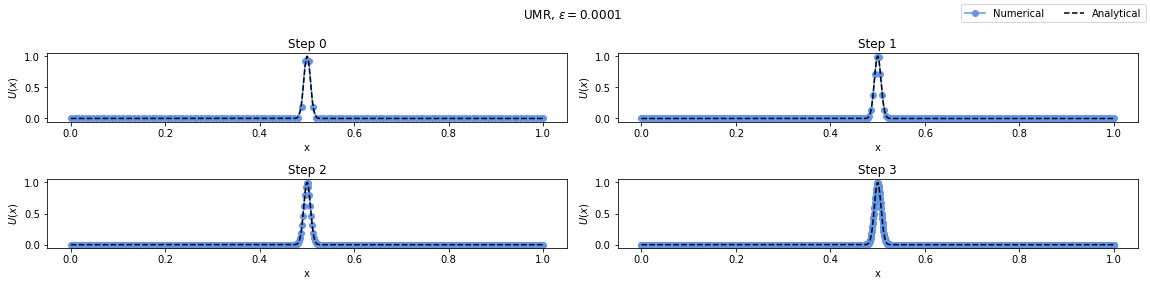

In [17]:
#by definition, UMR is doing this uniformly
#therefore we just need the list of n_s to construct them

def UMR(f,f_a,n_lst, FDM):
    err_L2 = np.zeros(len(n_lst))
    err_l2 = np.zeros(len(n_lst))
    i=0
    xs=np.linspace(0,1,1000)
    plt.figure(figsize=(16,4))
    for n in n_lst:
        X = np.linspace(0,1,n)
        Us = FDM(X, f)
        
        spline_err = np.zeros(len(X)-1)
        
        u_num = interp1d(X,Us,kind = 'cubic')
        
        diff = lambda x: (u_num(x) - f_a(x))**2
        lower = lambda x: f_a(x)**2
        
        for j in range(len(X)-1):
            spline_err[j] = np.sqrt(quad(diff,X[j],X[j+1])[0])
        
        #making a pretty picture
        plt.subplot(2,2,i+1)
        plt.plot(X,u_num(X),"-o",color='cornflowerblue')
        plt.plot(xs,f_a(xs),"--k")
        #plt.ylabel("Error")
        #plt.bar(0.5*(X[1:]+X[:-1]),spline_err,width=(0.01+(X[-1]-X[0])/len(X)),log=False,color="cornflowerblue")
        
        plt.xlabel("x")
        plt.ylabel("$U(x)$")
        plt.title("Step " + str(i))

        #finding the error for the whole function
        err_L2[i] = np.sqrt(quad(diff,X[0],X[-1])[0])/np.sqrt(quad(lower,X[0],X[-1])[0])

        err_l2[i] = np.linalg.norm(f_a(X)-Us)/np.linalg.norm(f_a(X))
        
        i+=1
    plt.plot(X,u_num(X),"-o",color='cornflowerblue',label="Numerical")
    plt.plot(xs,f_a(xs),"--k",label="Analytical")
    plt.suptitle("UMR, $\epsilon = 0.0001$")
    plt.figlegend(ncol=np.int(3), labelspacing=0. )
    plt.tight_layout()
    plt.savefig('1d_umr.png',bbox_inches="tight")
    plt.show()
        
    return err_L2, err_l2
    
ns = 2**np.linspace(7,10,4,dtype=int)

xs = np.linspace(0,1,100)

fs = lambda x: f(x,0.0001)

us = lambda x: u(x,0.0001)

L2_3pt, l2_3pt = UMR(fs,us,ns, FDM_3pt)


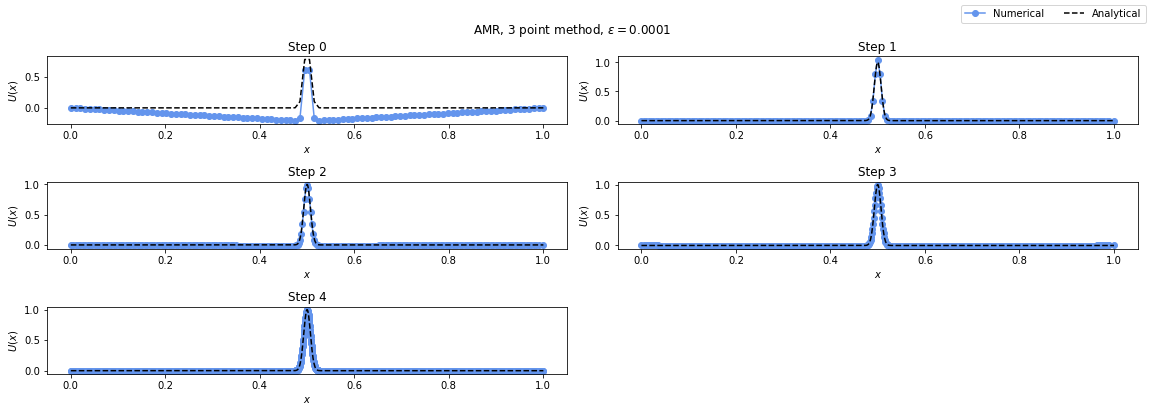

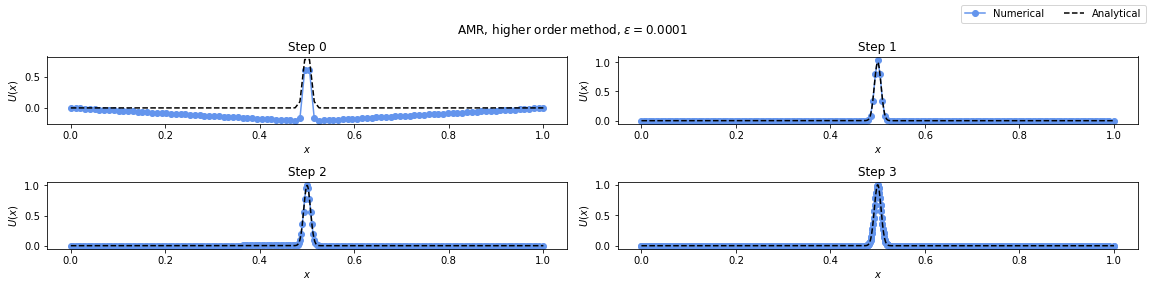

In [19]:
avg_errs_3pt = avg_AMR(fs,us,xs,FDM_3pt)
avg_errs_higher = avg_AMR(fs,us,xs,FDM_higher)

In [15]:
#creating relative errors

relative_3pt = avg_errs_3pt
relative_higher = avg_errs_higher

amt_3ptavg = np.shape(avg_errs_3pt)[0]
amt_higheravg = np.shape(avg_errs_higher)[0]

u_an = lambda x: fs(x)**2
lower = np.sqrt(quad(u_an,0,1)[0])
relative_3pt[:,1] = avg_errs_3pt[:,1]/lower
relative_higher[:,1] = avg_errs_higher[:,1]/lower


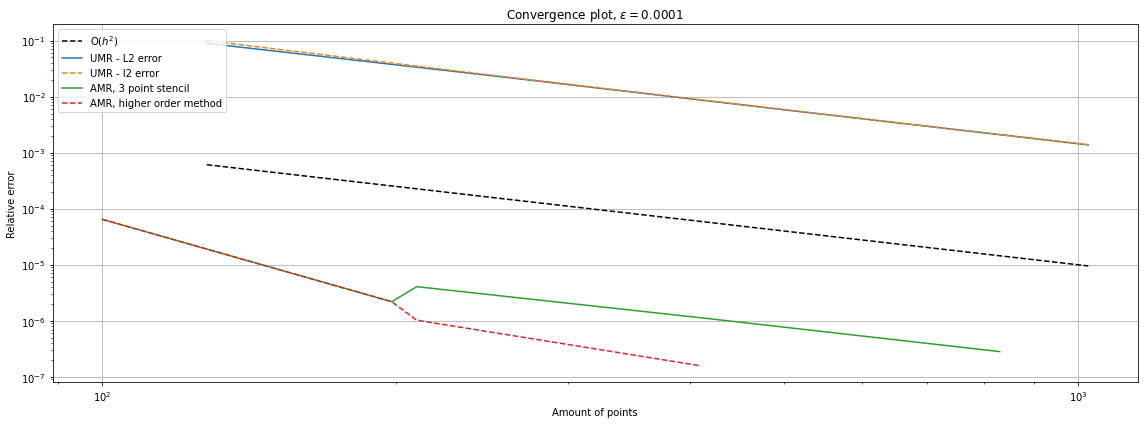

In [16]:
plt.figure(figsize = (16,6))
plt.loglog(ns,10*(1/ns)**2,"--k", label="O($h^2$)")
plt.loglog(ns,L2_3pt,label="UMR - L2 error")
plt.loglog(ns,l2_3pt,"--",label="UMR - l2 error")
plt.loglog(avg_errs_3pt[:,0], avg_errs_3pt[:,1],label ="AMR, 3 point stencil")
plt.loglog(avg_errs_higher[:,0], avg_errs_higher[:,1],"--",label ="AMR, higher order method")
plt.xlabel("Amount of points")
plt.ylabel("Relative error")
plt.title("Convergence plot, $\epsilon = 0.0001$")
plt.legend(loc=2)
plt.tight_layout()
plt.grid()
plt.savefig('1d_convplot.png')
plt.show()
